Intro to the notebook, explanation of what we are doing. We should have a discussion of the cifar dataset, and the size of the images (32x32x3).

In [9]:
import torch
import torch.nn as nn
import torch.functional as F
import numpy as np

from torchvision.datasets import mnist, cifar
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

from random import sample
from torch.autograd import Variable
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

%matplotlib inline

No need for much of an explanation for this one. This class is just to allow for loading of the data efficiently. There are some lines added to let it train faster, but the pictures aren't great anymore.

In [10]:
class DataLoad():
    
    def __init__(self):
        pass
    
    def load_data_mnist(self, batch_size=128):
        
        mnist_data = mnist.MNIST(root = './data/mnist',
                                train = True,
                                download = True,
                                transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5],[0.5])]))
        
        # Comment this line out if you wish to use the full dataset.
        mnist_data = torch.utils.data.Subset(mnist_data, sample(list(range(0,30000)), batch_size*100)) 
        
        mnist_loader = DataLoader(mnist_data, 
                                  batch_size = batch_size, 
                                  shuffle=True)
        
        return mnist_loader
    
    def load_data_cifar10(self, batch_size=128):
        
        cifar_data = cifar.CIFAR10(root = './data/cifar10',
                                  train = True,
                                  download = True,
                                  transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5],[0.5])]))
        
        # Comment these two lines out if you wish to use the full dataset.
        sample_range = sample(list(range(0,25000)), batch_size*120)
        cifar_data = torch.utils.data.Subset(cifar_data, sample_range)
        
        cifar_loader = DataLoader(cifar_data,
                                  batch_size = batch_size,
                                  shuffle = True)
        
        return cifar_loader        

In [11]:
def load_data(ds):
    
    # Initialize the dataloader
    data_loader = DataLoad()
    
    # Load training data into the dataloader
    if ds == 'mnist':
        train_loader = data_loader.load_data_mnist(batch_size = batch_size)
    elif ds == 'cifar10':
        train_loader = data_loader.load_data_cifar10(batch_size = batch_size)
    
    return train_loader



Here we should have a discussion of what we want the generator to be doing. I'll be removing the dimensions for the sequential parts, mainly the noise_dim part, unless you think we should remove a bit more of the internal part, but it might be too much to ask people to reconstruct it.

In [12]:
class Generator(nn.Module):
    
    def __init__(self, model_type, noise_dim=100):
        
        super(Generator, self).__init__()
        
        self.model_type = model_type
        self.image_shape = {'mnist': (1,28,28),
                           'cifar10': (3,32,32)}
        
        self.models = nn.ModuleDict({
            
            'mnist': nn.Sequential(
                            nn.Linear(noise_dim, 128, bias = True),
                            nn.LeakyReLU(0.2, inplace=True),
                            nn.Linear(128,256, bias = True),
                            nn.LeakyReLU(0.2, inplace=True),
                            nn.Linear(256,512, bias = True),
                            nn.LeakyReLU(0.2, inplace=True),
                            nn.Linear(512, 1024, bias=True),
                            nn.LeakyReLU(0.2, inplace=True),
                            nn.Linear(1024, int(np.prod(self.image_shape[model_type]))),
                            nn.Tanh()                
                            ),
            
            'cifar10': nn.Sequential(
                            nn.Linear(noise_dim, 128, bias = True),
                            nn.LeakyReLU(0.2, inplace=True),
                            nn.Linear(128,256, bias = True),
                            nn.LeakyReLU(0.2, inplace=True),
                            nn.Linear(256,512, bias = True),
                            nn.LeakyReLU(0.2, inplace=True),
                            nn.Linear(512, 1024, bias=True),
                            nn.LeakyReLU(0.2, inplace=True),
                            nn.Linear(1024, 2048, bias = True),
                            nn.LeakyReLU(0.2, inplace=True),
                            nn.Linear(2048, int(np.prod(self.image_shape[model_type]))),
                            nn.Tanh()                
                            ),
                })
        
    def forward(self, z):
        img = self.models[self.model_type](z)
        img = img.view(img.size(0), *self.image_shape[self.model_type])            
        return img

Same as for the generator. Maybe give the option for how many layers they want to do?

In [13]:
class Discriminator(nn.Module):
    
    def __init__(self, model_type):
        
        super(Discriminator, self).__init__()
        
        self.model_type = model_type
        self.image_shape = {'mnist': (1,28,28),
                           'cifar10': (3,32,32)}
        
        self.models = nn.ModuleDict({
            'mnist': nn.Sequential(
                            nn.Linear(int(np.prod(self.image_shape[model_type])),512),
                            nn.LeakyReLU(0.2, inplace=True),
                            nn.Linear(512,256),
                            nn.LeakyReLU(0.2, inplace=True),
                            nn.Linear(256,1),
                            nn.Sigmoid(),
                ),
            
            'cifar10': nn.Sequential(
                            nn.Linear(int(np.prod(self.image_shape[model_type])),1024),
                            nn.LeakyReLU(0.2, inplace=True),
                            nn.Linear(1024,512),
                            nn.LeakyReLU(0.2, inplace=True),
                            nn.Linear(512,256),
                            nn.LeakyReLU(0.2, inplace=True),
                            nn.Linear(256,1),
                            nn.Sigmoid(),
                ),
            })
        
    def forward(self, img):        
        img_flat = img.view(img.size(0),-1)
        output = self.models[self.model_type](img_flat)        
        return output

In [14]:
# This is just in case

cuda = True if torch.cuda.is_available() else False
device = 'cuda' if cuda else 'cpu'
device

'cpu'

In [16]:
# Generate some fixed noise to use down the road.

noise_dim = 100

fixed_noise = torch.randn(16, noise_dim, device=device)

# Set real/fake designations:

real = float(1)
fake = float(0)

Leave batch_size, and dataset, but remove the values for learning_rate, total_epochs, noise_dim, and k.

In [17]:
# Input arguments in this block
batch_size = 32
total_epochs = 100
dataset = 'cifar10'
learning_rate = 2e-4
beta1 = 0.5
beta2 = 0.999
noise_dim = 100
k = 2

In [18]:
# Load training data:
dataset = 'mnist' # 'mnist' or 'cifar10'
train_loader = load_data(dataset)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./data/mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/mnist/MNIST/raw



In [19]:
# Loss function

criterion = torch.nn.BCELoss()

# Initialize generator and discriminator

generator = Generator(dataset)
discriminator = Discriminator(dataset)

if cuda:
    generator.cuda()
    discriminator.cuda()
    criterion.cuda()

In [20]:
# Optimizers

optimizer_generator = torch.optim.Adam(generator.parameters(), lr = learning_rate, betas = (beta1, beta2))
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr = learning_rate, betas = (beta1, beta2))


AttributeError: 'function' object has no attribute 'clear_output'

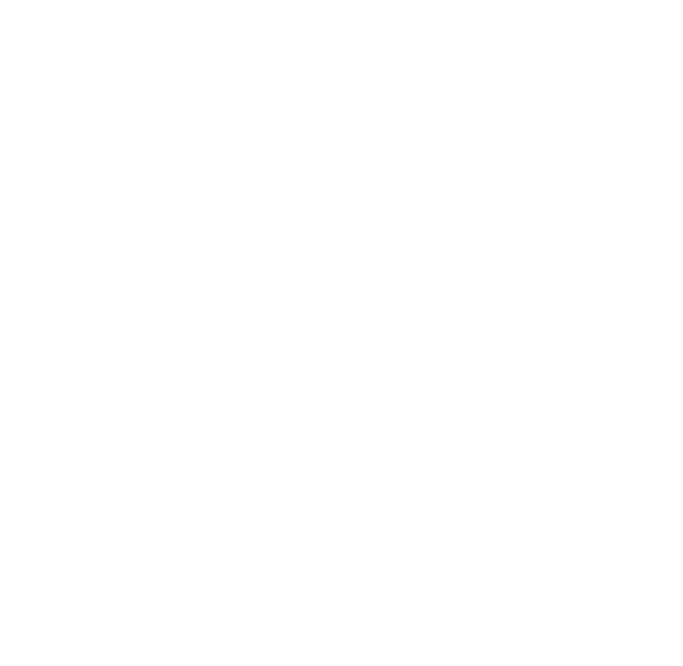

In [21]:
# Training Loop

fig, ax = plt.subplots(figsize=(12, 12))
ax.axis('off')

for epoch in range(total_epochs):
    # update the discriminator k times before updating the generator
    for i, (imgs, _) in enumerate(train_loader):
        
        imgs = imgs.to(device)
        
        valid = Variable(torch.Tensor(imgs.size(0),1).fill_(real), requires_grad=False).to(device)
        false = Variable(torch.Tensor(imgs.size(0),1).fill_(fake), requires_grad=False).to(device)
        
        optimizer_discriminator.zero_grad()
        
        # Calculate the loss on the all-real batch
        real_loss = criterion(discriminator(imgs), valid)
        
        # Generate some random noise        
        noise = Variable(torch.Tensor(np.random.normal(0,1, (imgs.shape[0], noise_dim)))).to(device)
        
        # Generate fake images by putting random noise through the generator function
        gen_imgs = generator(noise)
        
        # Classify the generated images with the discriminator and then calculate loss on the all-fake batch
        fake_loss = criterion(discriminator(gen_imgs.detach()), false)
        
        # Add the gradients from the all-real and all-fake batches
        
        loss_D = real_loss + fake_loss # Maybe leave this blank?
        
        # Calculate the gradients        
        loss_D.backward()
        
        # Update D
        optimizer_discriminator.step()
        
        
        # Update generator network: maximize log(D(G(z)))
        # This only fires after k steps of discriminator optimization
        
        if (epoch+1)%k == 0:
            optimizer_generator.zero_grad()

            # fake labels are real for generator cost
            # Since we just updated our discriminator, we need to do another forward pass of an all-fake batch
            # through our discriminator

            gen_imgs = generator(noise)
            output = discriminator(gen_imgs)

            # Now we need to calculate the probability of the discriminator classifying the fake images as real
            # If this probability is close to 0, then the generator has learnt how to fool the discriminator

            D_x = output.mean().item()

            # Calculate the generator's loss based on this

            loss_G = criterion(output, valid)

            loss_G.backward()

            # Calculate gradients for the generator:
            optimizer_generator.step()
    

    display.clear_output(wait=True)
    display.display(plt.gcf())

    fake_sample = generator(fixed_noise)
    image_grid = make_grid(fake_sample.to(device),
                           padding=2,
                           nrow=4,
                           normalize = True)
    ax.imshow(image_grid.cpu().permute(1,2,0))
    ax.set_title('[%d/%d]|Loss_D: %.4f|Loss_G: %.4f|D(x): %.4f'
                % (epoch+1, total_epochs, 
                    loss_D.item(),
                    loss_G.item(),
                    D_x),
                size=18)
